In [3]:
BIN = 4

In [1]:
import sys
import os
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
import zfit

import random
import json
import pandas as pd
from time import time

import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep

import scipy.stats as stats
from scipy.optimize import minimize

sys.path.append('..')
import SLSQP_zfit
import time

import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
class decayWidth(zfit.pdf.BasePDF):  
    """
    Decay width of the decay:
    bu -> su mu mu
    """
    def __init__(self, AFB, FH, obs, name="angular_dist" ):
        # se debe definir los parametros a pasar a la pdf
        params = {
              'AFB': AFB,
              'FH': FH, }
        super().__init__(obs, params, name=name)


    def _unnormalized_pdf(self, x):
        #cos_l, mass = x.unstack_x()
        cos_l = zfit.ztf.unstack_x(x)

        AFB, FH = self.params['AFB'], self.params['FH']

        # aqui definimos la pdf
        #alpha_lambda = 0.642
        cos2_l = cos_l*cos_l

        pdf = 3/4*(1-FH)*(1-cos2_l)
        pdf += 1/2*FH
        pdf += AFB*cos_l

        return pdf

In [5]:
with open(f'Params/Bin{BIN}.json') as f:
    params = json.load(f)

In [6]:
cos = zfit.Space(obs='cosThetaKMu', limits=[-1,1])
mass = zfit.Space(obs='BMass', limits=[5,5.7])

afb_ini = params['Signal']['angle']['AFB']
fh_ini = params['Signal']['angle']['FH']

AFB = zfit.Parameter('A_FB', afb_ini)
FH = zfit.Parameter('F_H', fh_ini)
decay = decayWidth(AFB = AFB, FH=FH, obs=cos)

efficiency = zfit.pdf.Chebyshev(obs=cos, 
                    coeffs=params['Signal']['angle']['Chi2EffyCoefs'][1:])

decay_eff = zfit.pdf.ProductPDF(pdfs=[decay, efficiency], obs=cos)

L = params['Background']['angle']['2SideBands']['Left']
background_LGauss = zfit.pdf.Gauss(mu = L['mu'], sigma=L['sigma'], obs=cos )
background_LCheby = zfit.pdf.Chebyshev(coeffs=L['coefs'][1:], obs=cos )
background_L = zfit.pdf.SumPDF(pdfs=[background_LCheby, background_LGauss], fracs=L['fraction_Cheby'])

R = params['Background']['angle']['2SideBands']['Right']
background_RGauss = zfit.pdf.Gauss(mu = R['mu'], sigma=R['sigma'], obs=cos )
background_RCheby = zfit.pdf.Chebyshev(coeffs=R['coefs'][1:], obs=cos )
background_R = zfit.pdf.SumPDF(pdfs=[background_RCheby, background_RGauss], fracs=R['fraction_Cheby'])

frac_ = zfit.Parameter(name='Background_frac', value=0.5)
background_angular = zfit.pdf.SumPDF(pdfs=[background_L, background_R], fracs=frac_, name='background_Sidebands')


mass_signal_params = params['Signal']['mass']['2Gaussian+CrystalBall']

signalCB = zfit.pdf.CrystalBall(mu=mass_signal_params['muCB'], 
                                sigma=mass_signal_params['sigmaCB'], 
                                alpha=mass_signal_params['alphaCB'], 
                                n=mass_signal_params['nCB'], 
                                obs=mass, 
                                name='signal_CrystalBall')

signalG1 = zfit.pdf.Gauss(mu=mass_signal_params['muGauss'], 
                          sigma=mass_signal_params['sigmaGauss1'], 
                          obs=mass, 
                          name='signal_Gaussian1')

signalG2 = zfit.pdf.Gauss(mu=mass_signal_params['muGauss'], 
                          sigma=mass_signal_params['sigmaGauss2'], 
                          obs=mass, 
                          name='signal_Gaussian2')

fracs = mass_signal_params['fracCB'], mass_signal_params['fracGauss1'], mass_signal_params['fracGauss2']

signal_mass = zfit.pdf.SumPDF([signalCB, signalG1, signalG2], fracs=[fracs[0]/sum(fracs), fracs[1]/sum(fracs)], 
                          name='signal_CB+2Gauss')

mass_background_params = params['Background']['mass']['Exponential+Gauss']


backExponential = zfit.pdf.Exponential(lambda_=mass_background_params['lambda_'], 
                            obs=mass,
                            name='background_Exponential')

backBGauss = zfit.pdf.Gauss(mu=mass_background_params['mu'],
                            sigma=mass_background_params['sigma'],
                            obs=mass,
                            name='background_Gaussian')

background_mass = zfit.pdf.SumPDF([backExponential, backBGauss], fracs=mass_background_params['fraction_exp'], 
                          name='background_Gauss+Exp')

complete_signal = signal_mass*decay_eff
complete_background = background_mass*background_angular


s_ini, b_ini = params['Signal']['yield'], params['Background']['yield']
Total = s_ini + b_ini
S = zfit.Parameter('signalYield', s_ini, 0, Total)
B = zfit.Parameter('backgroundYield', b_ini, 0, Total)

signal_extended = complete_signal.create_extended(yield_=S)
background_extended = complete_background.create_extended(yield_=B)

#---------------------------------------------------------------------#
#---------------------------------------------------------------------#
complete_pdf = signal_extended+background_extended
#---------------------------------------------------------------------#
#---------------------------------------------------------------------#

/home/horacio/Documents/pycms/lib64/python3.6/site-packages/zfit/core/basepdf.py:443: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  "As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). This"


In [8]:
sampler = complete_pdf.create_sampler()

In [17]:
sampler.resample()
dataframe = sampler.to_pandas()

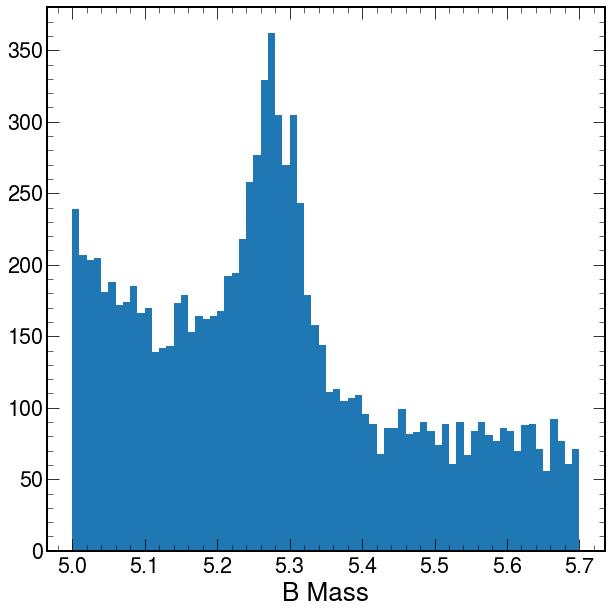

In [22]:
plt.hist(dataframe.BMass, bins=70)
plt.xlabel('B Mass')
plt.show()

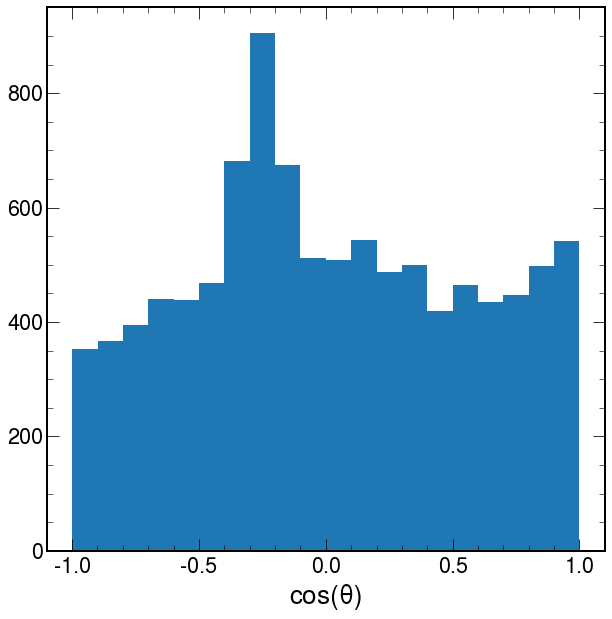

In [25]:
plt.hist(dataframe.cosThetaKMu, bins=20)
plt.xlabel(r'cos($\theta$)')
plt.show()

In [26]:
DATA_Z = zfit.Data.from_pandas(df = dataframe,obs=complete_pdf.obs) 
NLL_DATA =  zfit.loss.ExtendedUnbinnedNLL(complete_pdf, DATA_Z)

/home/horacio/Documents/pycms/lib64/python3.6/site-packages/zfit/core/loss.py:159: AdvancedFeatureWarning: Either you're using an advanced feature OR causing unwanted behavior. To turn this warning off, use `zfit.settings.advanced_warnings['inconsistent_fitrange']` = False`  or 'all' (use with care) with `zfit.settings.advanced_warnings['all'] = False
PDFs [<zfit.SumPDF  params=[Composed_autoparam_46, Composed_autoparam_47] dtype=float64>0] as well as `data` [<zfit.core.data.Data object at 0x7f62d42c3278>] have different ranges [(<zfit Space obs=('BMass', 'cosThetaKMu'), axes=(0, 1), limits=(array([[ 5., -1.]]), array([[5.7, 1. ]]))>, <zfit Space obs=('BMass', 'cosThetaKMu'), axes=(0, 1), limits=None>)] they are defined in. The data range will cut the data while the norm range defines the normalization.
  identifier='inconsistent_fitrange')


In [27]:
constAngParams_Full = ({'type': 'ineq', 'fun': lambda x:  x[3]},
                 {'type': 'ineq', 'fun': lambda x:  3-x[2]},
                 {'type': 'ineq', 'fun': lambda x:  x[3]/2-x[2]},
                 {'type': 'ineq', 'fun': lambda x:  x[3]/2+x[2]})

SLSQP_FULL = SLSQP_zfit.SLSQP(constraints=constAngParams_Full )

In [28]:
minimize_FULL = SLSQP_FULL.minimize(NLL_DATA)

In [29]:
minimize_FULL

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.SumPDF  params=[Composed_autoparam_46, Composed_autoparam_47] dtype=float64>0] data=[<zfit.core.data.Data object at 0x7f62d42c3278>] constraints=[]> 
with
<function minimize at 0x7f637c0f3ea0>

╒═════════╤═════════════╤══════════════════╤═══════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm   │ min value   │
╞═════════╪═════════════╪══════════════════╪═══════╪═════════════╡
│ True    │ True        │ False            │ -1    │ -8.089e+04  │
╘═════════╧═════════════╧══════════════════╧═══════╧═════════════╛

Parameters
name                value    at limit
---------------  --------  ----------
signalYield          2089       False
backgroundYield      7981       False
A_FB             0.008937       False
F_H                0.2135       False
Background_frac    0.5243       False

In [30]:
afb_ini, fh_ini

(0, 0.2)